In [2]:
from scipy.spatial.distance import pdist
import collections
import seaborn as sns
import subprocess
import numpy as np
import itertools as it
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from  imp import reload
import sys
# enter top-k-mallows directory
sys.path.append('top-k-mallows/')
import mallows_kendall as mk
import permutil as pu
import partial_rankings as prank
from scipy.stats import norm
from scipy.spatial.distance import pdist

## synthetic for PL,
find the approp dispersion

<AxesSubplot: xlabel='Concentration', ylabel='sure_pair'>

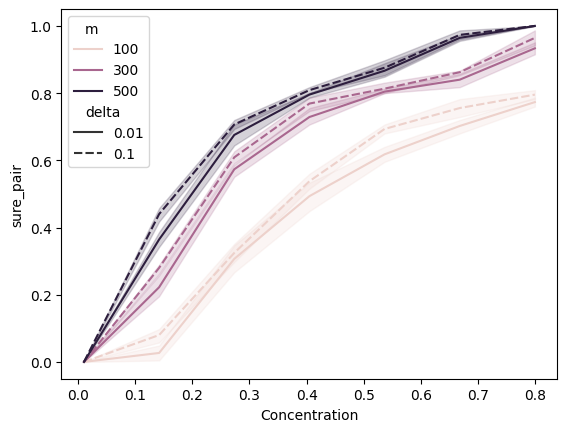

In [3]:
n = 10
verbose = True
delta = 0.1
res = []
#theta_mm = 
repes = 5
total_pairs = n*(n-1)/2
for repe in range(repes):
  for delta in [.01,.1,]:
    for m in [100,300,500]:
      for Concentration in np.linspace(.01,.8,7):# [.01,.3,.5,.7,.9, 1]:
        # PL with dispersion = 0 => uniform
        w = np.array([np.exp(i*Concentration) for i in reversed(range(n))]) #deelta distr
        sample = pu.plackett_luce_sample(m,n,w=w)
        #center = np.arange(n) #np.random.permutation(n)
#        sample = mk.sample(m=m,n=n,theta=theta_mm, s0=center)
        p_total = np.zeros((n,n)) # p_total[i,j] counts the number of times i IS PREFERRED to j
        p_ranks = sample
        for perm in p_ranks:
          p, _, _ = prank.p_rank_to_mat(perm, return_ratios=True, return_num_comparisons=True)
          p = p.astype('float64')
          p_total = p_total + p
        p_total = (p_total/len(p_ranks))

        borda_rank = prank.borda_mat(p_total)
        CIs = np.zeros((n,n))
        for i in range(n):
          for j in range(i+1,n):
            CIs[i,j] = np.sqrt( 1/(2*m) * np.log( (4 * n * m**2)/delta))
            CIs[j,i] = CIs[i,j]
        #print(CIs.round(2),"CI")

        inCI, sure_pair = 0, 0
        for i in range(n):
          for j in range(i+1,n):
            a = ( p_total[i,j] - CIs[i,j] )
            b = ( p_total[i,j] + CIs[i,j] )
            if a<.5 and .5<b:  inCI += 1
            else: sure_pair += 1
        res.append([Concentration, delta, m, sure_pair/total_pairs, inCI/total_pairs])
df = pd.DataFrame(res,columns=['Concentration','delta','m','sure_pair', 'inCI'])
sns.lineplot(data=df,hue='m',y='sure_pair',x='Concentration',style='delta')

<AxesSubplot: xlabel='Concentration', ylabel='inCI'>

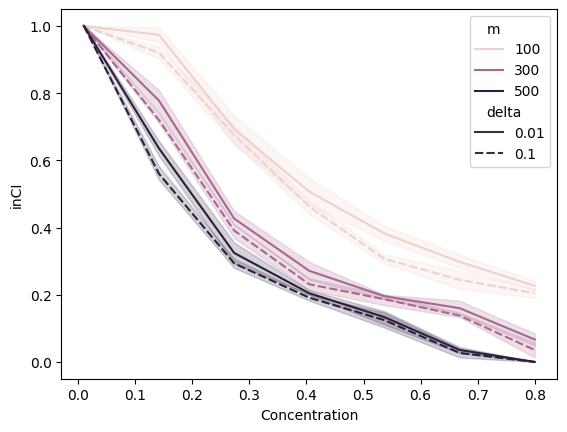

In [4]:
sns.lineplot(data=df,hue='m',y='inCI',x='Concentration',style='delta')

In [5]:
#Aggregation functions
import random
def phi_to_w(phi,n):
  return np.exp([n-phi*i for i in range(n)])
def rand_argsort(arr):
  # if all nan: return np.random.permutation(range(len(arr)))
  if np.isnan(arr).all(): return np.random.permutation(range(len(arr)))
  # if np.all(np.isclose(arr, arr[0])): return np.random.permutation(range(len(arr)))
  #print(arr,np.argsort(arr))
  nan_indices = np.argwhere(np.isnan(arr)).reshape(1,-1)[0]
  #tied_indices: add a random num that does not change the rder
  unique_vals, counts = np.unique(arr, return_counts=True)
  # print(arr)
  # print(unique_vals, counts)
  if any(counts>1):
    #print(unique_vals, counts)
    #check if the non nan values are all the same
    if len([i for i in unique_vals if not np.isnan(i)])==1:
      smallest_diff = 1
    else:
      smallest_diff = np.min(np.diff(unique_vals[~np.isnan(unique_vals)]))
    ran = np.random.random(len(arr))*smallest_diff
    arr = arr + ran
  #nan: shuffle the 2 lists
  lis = []
  k = len(arr) - len(nan_indices)
  pile1, pile2 = list(nan_indices),list(np.argsort(arr)[:k])
  #print(pile1, pile2)
  for _ in range(len(arr)):#shuffle
    if len(pile1)==0: lis.append(pile2.pop())
    elif len(pile2)==0: lis.append(pile1.pop())
    elif np.random.random()>.5:   
      lis.append(pile2.pop())
    else:
      lis.append(pile1.pop()) 
  lis = lis[::-1]
  return lis

def coarse(data, eta):
  aux = honest_full.copy()
  for n in range(N):
    for t in range(T):
      if np.random.random() < eta:
        aux[t,:,n] = np.nan
  return aux

In [6]:

def mean_randargsort(arr):
  return prank.rank_data_nan(arr.mean(axis=1).mean(axis=0))
def onelevel(arr):
  p_total = np.zeros((N,N))
  for permscore in arr.reshape(T*I,N):
    mask = np.isnan(permscore)
    perm = permscore.argsort().astype(float)
    perm[mask] = np.nan
    p = prank.p_rank_to_mat(perm, return_ratios=True)
    p_total += p
  return prank.borda_mat(p_total)

def twolevel(arr):
  first_level = np.zeros((T,N))
  for t in range(T):
    p_total = np.zeros((N,N))
    for i in range(I):
      permscore = arr[t,i,:].copy()
      mask = np.isnan(permscore)
      perm = permscore.argsort().astype(float)
      perm[mask] = np.nan
      p = prank.p_rank_to_mat(perm, return_ratios=True)
      p_total += p
      first_level[t,:] = prank.borda_mat(p_total)
  return first_level.sum(axis=0).argsort().argsort()
def average_pairwise_dist(arr):
  return pdist(arr.reshape(T*I,N).argsort()).mean()

when scallingeven at 0 there are errors because the manipulation is done after evaluating r0_mean

(phi_honest
 0.01    16.696445
 0.50     9.207563
 0.90     5.725989
 Name: avg_dist, dtype: float64,
 66.0)

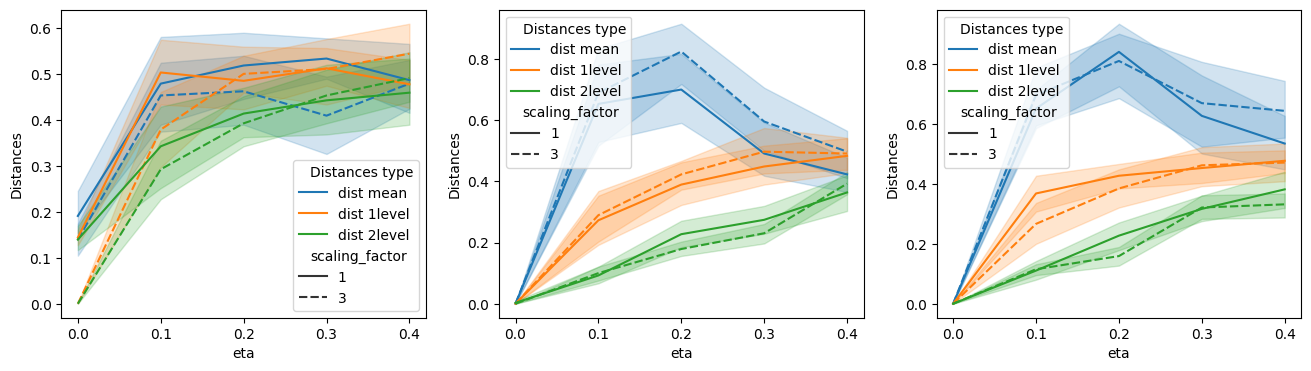

In [7]:
N = 12 # numer of systems (n)
T = 10 # numner of task (m)
I = 13 # number of instance (p)
repes = 10
max_dist = N*(N-1)/2
phis_honest = [.01,.5,.9] #.05, .3
scaling_factors  = [1, 3]
etas = [0, .1, .2,.3,.4]#, .1,.2,.3, .4,  .5, .8
res = []
for repe in range(repes):
  for phi_honest in phis_honest : #np.linspace(0,.1, 2):
    honest_full = np.array([np.random.gumbel(-np.log(phi_to_w(phi_honest,N)), 1)[::-1] for i in range(T*I)])
    honest_full -= honest_full.min() #to have positives
    honest_full = honest_full.reshape(T,I,N)
    avg_dist = average_pairwise_dist(honest_full)
    r0_mean = mean_randargsort(honest_full)
    r0_onelev = onelevel(honest_full)
    r0_twolev = twolevel(honest_full)
    for scaling_factor in scaling_factors:
      aux = honest_full[0,:,:]
      honest_full[0,:,:] = (-aux + aux.max() +aux.min())*scaling_factor#manipulate one task and scale it
      for eta in etas:
        arr = coarse(honest_full, eta)
        r_mean = mean_randargsort(arr)
        r_onelev = onelevel(arr)
        r_twolev = twolevel(arr)
        d1, d2, d3 = mk.distance(r0_mean, r_mean)/max_dist, mk.distance(r0_onelev, r_onelev)/max_dist, mk.distance(r0_twolev, r_twolev)/max_dist
        res.append([repe,phi_honest, scaling_factor, eta,avg_dist, d1, d2, d3])
df = pd.DataFrame(res, columns=['repe','phi_honest','scaling_factor', 'eta', 'avg_dist','dist mean', 'dist 1level', 'dist 2level'])
df = df.melt(id_vars=['repe','phi_honest','scaling_factor', 'eta','avg_dist'], var_name='Distances type', value_name='Distances')
f, ax = plt.subplots(1,len(phis_honest), figsize=(16,4))
for indi,phi in enumerate(phis_honest): # sns.lineplot(data=df[phi_honest==phi],x='eta',y='Distances', hue='Distances type', style='scaling_factor')
    aux = df[df.phi_honest==phi]
    sns.lineplot(data=aux,x='eta',y='Distances', hue='Distances type', style='scaling_factor', ax=ax[indi])
df.groupby(['phi_honest']).avg_dist.mean(), max_dist

In [8]:
def corrupt( scores, num_corrupted_tasks):
  rand_order_of_tasks = np.random.permutation(range(T))
  arr = scores.copy()
  for corrupted_task in rand_order_of_tasks[:num_corrupted_tasks]:
    aux = arr[corrupted_task,:,:]
    arr[corrupted_task,:,:] = (-aux + aux.max() +aux.min())#manipulate one task 
  return arr

(phi_honest
 0.01    16.700678
 0.10    15.651505
 0.50     8.958953
 Name: avg_dist, dtype: float64,
 66.0)

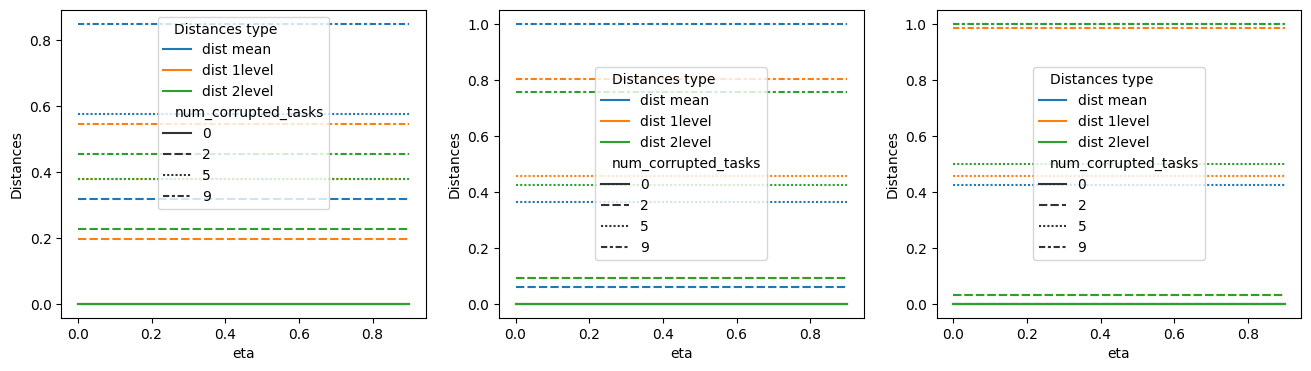

In [9]:
N = 12 # numer of systems (n)
T = 10 # numner of task (m)
I = 15 # number of instance (p)
repes = 1
max_dist = N*(N-1)/2
phis_honest = [.01,.1,.5] #.05, .3
etas = [0, .1, .5,.9]#, .1,.2,.3, .4,  .5, .8
res = []
nums_corrupted_tasks = [0,2,5,9]
for repe in range(repes):
  for phi_honest in phis_honest : #np.linspace(0,.1, 2):
    honest_full = np.array([np.random.gumbel(-np.log(phi_to_w(phi_honest,N)), 1)[::-1] for i in range(T*I)])
    honest_full -= honest_full.min() #to have positives
    honest_full = honest_full.reshape(T,I,N)
    avg_dist = average_pairwise_dist(honest_full)
    r0_mean = mean_randargsort(honest_full)
    r0_onelev = onelevel(honest_full)
    r0_twolev = twolevel(honest_full)
    for num_corrupted_tasks in nums_corrupted_tasks:
      arr = corrupt(honest_full, num_corrupted_tasks) 
      for eta in etas:
        r_mean = mean_randargsort(arr)
        r_onelev = onelevel(arr)
        r_twolev = twolevel(arr)
        d1, d2, d3 = mk.distance(r0_mean, r_mean)/max_dist, mk.distance(r0_onelev, r_onelev)/max_dist, mk.distance(r0_twolev, r_twolev)/max_dist
        res.append([repe,phi_honest, num_corrupted_tasks, eta,avg_dist, d1, d2, d3])
df = pd.DataFrame(res, columns=['repe','phi_honest','num_corrupted_tasks', 'eta', 'avg_dist','dist mean', 'dist 1level', 'dist 2level'])
df = df.melt(id_vars=['repe','phi_honest','num_corrupted_tasks', 'eta','avg_dist'], var_name='Distances type', value_name='Distances')
f, ax = plt.subplots(1,len(phis_honest), figsize=(16,4))
for indi,phi in enumerate(phis_honest): # sns.lineplot(data=df[phi_honest==phi],x='eta',y='Distances', hue='Distances type', style='scaling_factor')
    aux = df[df.phi_honest==phi]
    sns.lineplot(data=aux,x='eta',y='Distances', hue='Distances type', style='num_corrupted_tasks', ax=ax[indi])
df.groupby(['phi_honest']).avg_dist.mean(), max_dist